In [1]:
from __future__ import print_function
from collections import defaultdict,namedtuple
from scipy import stats

import numpy as np
import matplotlib.pyplot as plt
import os,math,random,time,csv,numpy,re,string

### Read the cleaned raw data
For detail of how data is made, look at `prepare_clean_training_for_Doc2Vec.py`

In [2]:
with open("product_data_new_titleAndLongShortDescription_clean.csv"
          , "rb") as file_in:
    reader = csv.reader(file_in)
    raw = [line for line in reader]

### Check the length of each field

In [3]:
# title_len, long_len, short_len = [], [], []
# for item in raw:
#     title_len.append(len(item[1].split()))
#     long_len.append(len(item[2].split()))
#     short_len.append(len(item[3].split()))

In [5]:
# # Show some descriptive statistics
# print(stats.describe(title_len))
# print()
# print(stats.describe(long_len))
# print()
# print(stats.describe(short_len))
# print()

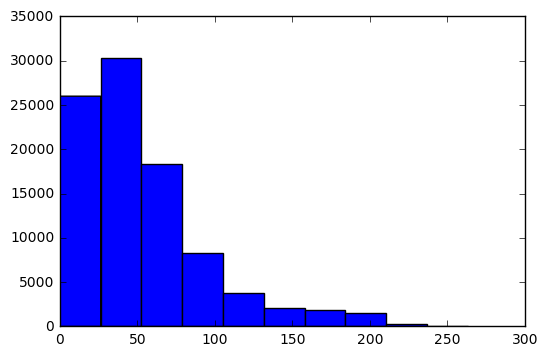

In [6]:
# # We are not going to use the short_len but the long_len.
# # However, it's very is very skewed
# plt.hist(long_len)
# plt.show()

In fact, some product long description includes sort of context stories to glorify the product. They might work for customers but will mislead our classifier. TO avoid this, we decides to cut-off the description after certain length.

### Training using the Doc2Vec provided by genism 

In [7]:
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
import gensim.models.doc2vec
import multiprocessing

In [8]:
# # Build the sentences for Doc2Vec training
# cut_off_length = 100

# sentences = []
# for item in raw:
#     tokens = item[1].split()
#     # A special character indicating the seperation between title and main text
#     tokens.append("#")
#     # Cut off the long description if neccessary
#     tokens.extend(item[2].split()[:100])
#     # Use id as label, not meaning at all in this application, just required by Doc2Vec
#     label = [item[0]]
    
#     # Convert into Doc2Vec format
#     sent = LabeledSentence(words = tokens, tags = label)
#     sentences.append(sent)

# # Make a copy of sentences
# # use the copy in actual training as it will be shuffled 
# sents = sentences[:]

# # Make sure multiple cores can be used
# cores = multiprocessing.cpu_count()
# assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

# # Use parameters copied from RaRe-Technologies/doc2vec-IMDB.ipynb
# model = Doc2Vec(dm=1, dm_concat=1, size=100, window=5,
#                 negative=5, hs=0, min_count=2, workers=cores)
# model.build_vocab(sents) # use the copy

### Actual training Doc2Vec

In [9]:
# # Training
# num_pass = 10
# for epoch in range(num_pass):
#     np.random.shuffle(sents) # randomized to have better representation
#     ts = time.time()
#     model.train(sents)
#     te = time.time()
#     print("Epoch {} takes {}s".format(epoch, round(te-ts,2)))

# # Epoch 0-8 takes around 250s each but Epoch takes 3258s!!! Why?

Epoch 0 takes 290.64s
Epoch 1 takes 272.59s
Epoch 2 takes 268.36s
Epoch 3 takes 263.01s
Epoch 4 takes 262.44s
Epoch 5 takes 259.01s
Epoch 6 takes 259.87s
Epoch 7 takes 258.51s
Epoch 8 takes 255.75s
Epoch 9 takes 256.82s


In [11]:
# When done, save the model
# store the model to mmap-able files
# model.save('product_data_new1.doc2vec')

### Use the Doc2Vec to build an SVM model

In [4]:
# Load the model
model = Doc2Vec.load('product_data_new1.doc2vec')

# Load the data
import helper, time, csv, json, math, random
path_data = '/home/jl/Projects/mps_project/training_data/new_cates.csv'
data = helper.load_csv(path_data, has_header = True)

In [14]:
# Clean the data use the same standard as in building Doc2Vec
for d in data:
    for i in range(2):
        d[i] = helper.clean_forDoc2Vec(d[i])

# Use the Doc2Vec model to infer each X
# using parameters copied from RaRe-Technologies/doc2vec-IMDB.ipynb
infer_steps = 3
infer_alpha = 0.1
data_v = []
for d in data:
    x = d[0].split()
    x.append("#")
    x.extend(d[1].split())
    x = model.infer_vector(x, steps=infer_steps, alpha=infer_alpha)
    y_main = d[3]
    y_sub = d[4]
    data_v.append([x, y_main, y_sub])

Now data_v has x, y_main and y_sub, let's build the model! 

In [15]:
# Train test split
train_portion = 0.7
random.seed(2016)
train_ids = set(random.sample([i for i in range(len(data_v))],\
                int(train_portion*len(data_v)))) # Use a set
train_X, train_Y, test_X, test_Y = [], [], [], []
for i, d in enumerate(data_v):
    if i in train_ids:
        train_x = d[0]
        train_y = d[1]
        train_X.append(train_x)
        train_Y.append(train_y)
    else:
        test_x = d[0]
        test_y = d[1]
        test_X.append(test_x)
        test_Y.append(test_y)

In [ ]:
# Training
from sklearn.svm import LinearSVC
ts = time.time()
clf = LinearSVC()
clf.fit(train_X, train_Y)
t1 = time.time()
print("Traning takes: {}s".format(round(t1-ts, 2)))

# Test
from sklearn.metrics import classification_report
Y_pred = clf.predict(test_X)
t2 = time.time()
print("Testing takes: {}s".format(round(t2-t1, 2)))
print(classification_report(test_Y, Y_pred))